# 03 People Object Detection

## What is object detection?

In Notebook01 & Notebook02, you have tried to perform image classification. Through these notebooks you can predict the type or class of an object in an image. However, another approah is needed for search and locate different objects inside the same image. Thus, we need object detection. It can locate the presence of objects with a bounding box and types or classes of the located objects in an image. 

![image](notebook_image/008.png)

## Import necessary python libraries

In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Configurations
These parameters indicate which model you are using and the input image of the network as well.

In [2]:
MODEL = 'ssd_mobilenet_v1_coco'
DATA_DIR = './data/'
CONFIG_FILE = MODEL + '.config'   # ./data/ssd_mobilenet_v1_coco.config 
CHECKPOINT_FILE = 'model.ckpt'    # ./data/ssd_mobilenet_v1_coco/model.ckpt
IMAGE_PATH = './data/people.jpg'

## Download the pretrained model

Model: ssd_mobilenet_v1

Input image: data/people.jpg

![image](notebook_image/009.jpeg)

In [3]:
config_path, checkpoint_path = download_detection_model(MODEL, 'data')

## Build the frozen graph

Freezing is the process to identify and save all of the required things such as graph and weights in a single file that can be easily used. A typical Tensorflow models contains 4 files including model-ckpt.meta, model-ckpt.model-ckpt.data-0000-of-00001, model-ckpt.index and checkpoint.


In [4]:
frozen_graph, input_names, output_names = build_detection_graph(
    config=config_path,
    checkpoint=checkpoint_path,
    score_threshold=0.3,
    batch_size=1
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from data/ssd_mobilenet_v1_coco_2018_01_28/model.ckpt
INFO:tensorflow:Restoring parameters from data/ssd_mobilenet_v1_coco_2018_01_28/model.ckpt
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.e

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb


INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb


INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


## Optimized the graph with TensorRT
NVIDIA TensorRT™ is an SDK for high-performance deep learning inference. It includes a deep learning inference optimizer and runtime that delivers low latency and high-throughput for deep learning inference applications.TensorRT is built on CUDA, NVIDIA’s parallel programming model, and enables you to optimize inference for all deep learning frameworks leveraging libraries, development tools and technologies in CUDA-X for artificial intelligence, autonomous machines, high-performance computing, and graphics.

![image](notebook_image/003.png)

1. input_graph_def -> frozen Tensorflow graph
2. outputs -> list of strings with names of output nodes
3. max_batch_size -> integer, size of input batch
4. max_worksapce_size_bytes -> integer, maximum GPU memory size availabele for TensorRT
5. precision_mode -> string, allowed values "FP32", "FP16" OR "INT8"
6. Minimum_segment_size -> integer(default = 3), control minimum number of nodes in a sub-graph for TensorRT engein to be created


In [5]:
print(output_names)

['detection_boxes', 'detection_classes', 'detection_scores', 'num_detections']


In [6]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Running against TensorRT version 5.0.6


INFO:tensorflow:Running against TensorRT version 5.0.6


In [7]:
with open('./data/ssd_inception_v1_coco_trt.pb', 'wb') as f:
    f.write(trt_graph.SerializeToString())

## Create session and load grap

In [8]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

## Load and Preprocess image

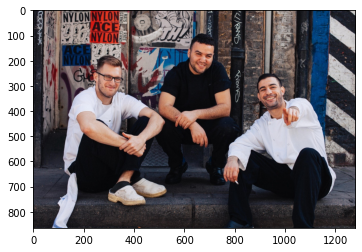

In [10]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image)

## Run network

In [11]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_resized[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = int(num_detections[0])


## Result visualization

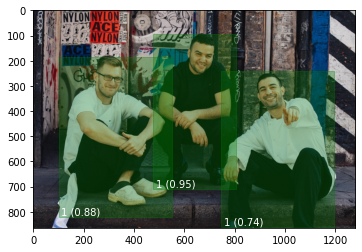

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(num_detections):
    
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

## Challenge

Question 1. What is the confidence level?

Question 2. How can I set a display threshold based on confidence level?



In [ ]:
# Type your answer here

In [ ]:
# Type your answer here

## Solutions of question 1

Confidence levels are the likelihood of the results being true for the total population and expressed in percentage form, for example 95%. So if you reproduced that sample or experiment repeatedly, 95% of the time you should see the same results if you counted the total population. 

## Solutions of question 2

0.9495163
0.88131577
0.7415973


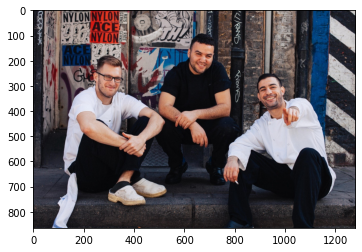

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(num_detections):
    # display the boundary boxes if the result is above the threshold
    if((scores[i]*100)>=80):
        # scale box to image coordinates
        box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

        # display rectangle
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
        ax.add_patch(patch)

        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()